# Goal: Create `bhp_nn_1ns`

From sparse `bhm` matrix.

# Load modules

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

In [2]:
os.getcwd()

'C:\\Users\\pfschus\\Box Sync\\Projects\\fnpc\\analysis\\ipol'

In [4]:
os.listdir('../../scripts')

['bicorr.py',
 'bicorr_e.py',
 'bicorr_main.py',
 'bicorr_math.py',
 'bicorr_plot.py',
 'bicorr_sim.py',
 'bicorr_sums.py',
 'combine_bhm_e.py',
 'combine_singles_hist.py',
 'combine_sparse_bhm.py',
 'fastpsd.i',
 'general.py',
 'plot_Asym_energy_space.py',
 'plot_counts_vs_angle_E.py',
 'plot_E_slices.py',
 'plot_slices_bhp_e.py',
 'process_all.sh',
 'psdcoeff.i',
 'readme.md',
 'scripts_from_flux.sh',
 'scripts_to_flux.sh',
 'sphinx',
 'tqdm',
 'wattE.m',
 '__pycache__']

In [5]:
sys.path.append('../../scripts/')

In [6]:
import bicorr as bicorr
import bicorr_plot as bicorr_plot

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import seaborn as sns
sns.set(style='ticks')

# Load data

## Array info

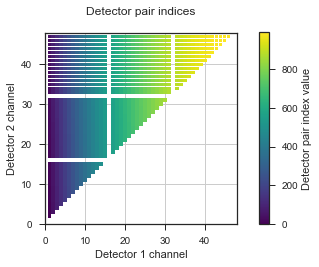

<Figure size 576x396 with 0 Axes>

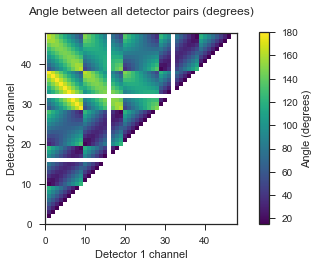

<Figure size 576x396 with 0 Axes>

In [9]:
det_df = bicorr.load_det_df('../../meas_info/det_df_pairs_angles.csv',plot_flag=True)

In [10]:
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists(print_flag=True)

Fission chamber channels: [ 0 16 32]
Detector channels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Number of detectors: 45
Number of detector pairs: 990


## Load and revive `sparse_bhm`

In [11]:
os.listdir()

['.ipynb_checkpoints',
 'check_sums.ipynb',
 'create_bhp_nn_1ns.ipynb',
 'datap',
 'fig',
 'plot_bhm_and_bhm_e.ipynb']

In [12]:
sparse_bhm, dt_bin_edges, note = bicorr.load_sparse_bhm(filepath='datap')

In [13]:
sparse_bhm.nbytes

175199673

In [14]:
bhm = bicorr.revive_sparse_bhm(sparse_bhm, det_df, dt_bin_edges)

In [15]:
bhm.shape

(990, 4, 800, 800)

# Coarsen `bhm`

In [16]:
print(bhm.shape)
print(dt_bin_edges[1]-dt_bin_edges[0])

(990, 4, 800, 800)
0.25


In [17]:
bhm, dt_bin_edges = bicorr.coarsen_bhm(bhm,dt_bin_edges,4,True)

Dimensions of bicorr_hist_master:  (990, 4, 800, 800)
Width of time bin in (ns):  0.25
Width of coarse time bin in (ns):  1.0
Condensing bhm from shape  (990, 4, 800, 800)  to  (990, 4, 200, 200)


In [18]:
print(bhm.shape)
print(dt_bin_edges[1]-dt_bin_edges[0])

(990, 4, 200, 200)
1.0


# Create `bhp_nn`

I'm going to ignore fission chamber neighbors.

In [19]:
pair_is = bicorr.generate_pair_is(det_df, ignore_fc_neighbors_flag=True)
len(pair_is)

861

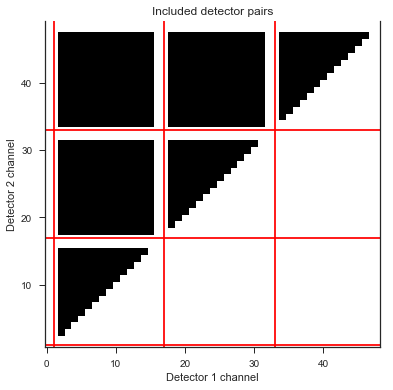

In [20]:
plt.figure(figsize=(6,6))
plt.plot(det_df.iloc[pair_is]['d1'],det_df.iloc[pair_is]['d2'],'sk')
for i in [1,17,33]:
    plt.axvline(i,c='r')
    plt.axhline(i,c='r')
plt.xlabel('Detector 1 channel')
plt.ylabel('Detector 2 channel')
plt.title('Included detector pairs')
sns.despine(right=False)
plt.show()

In [21]:
bhp_nn_shape = bhm[pair_is,0,:,:].shape
print(bhp_nn_shape)

(861, 200, 200)


In [22]:
bhp_nn = np.zeros(bhp_nn_shape)
bhp_nn.shape

(861, 200, 200)

In [23]:
for i in np.arange(len(pair_is)):
    pair_i = pair_is[i]
    
    bhp_nn[i,:,:] = bicorr.build_bhp(bhm,dt_bin_edges,pair_is=[pair_i],type_is=[0])[0]
    
print(bhp_nn.shape)

(861, 200, 200)


# Plot a few for quality control

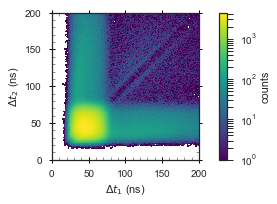

<Figure size 576x396 with 0 Axes>

In [24]:
bicorr_plot.bhp_plot(np.sum(bhp_nn[:,:,:],axis=0),dt_bin_edges,show_flag=True)

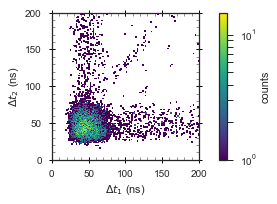

<Figure size 576x396 with 0 Axes>

In [25]:
i = 50
bicorr_plot.bhp_plot(bhp_nn[i,:,:],dt_bin_edges,show_flag=True)

# Store to disk

In [26]:
note = "Stored from IPOL simulation file with 1 ns time binning. Pairs are without fc neighbors. -PFS, 7/10/18"

In [27]:
save_filename = 'datap/bhp_nn_1ns'

In [28]:
np.savez(save_filename,
         bhp_nn = bhp_nn,
         dt_bin_edges = dt_bin_edges, 
         pair_is = pair_is,
         note = note)

In [29]:
os.listdir('datap')

['Asym_df.csv',
 'bhm_e.npz',
 'bhp_nn_1ns.npz',
 'by_angle_e_df.csv',
 'det_df_e_filled.csv',
 'det_df_e_ignorefc_filled.csv',
 'Esum_df.csv',
 'num_fissions.mat',
 'singles_e_df_filled.csv',
 'singles_hist.npz',
 'singles_hist_e_n.npz',
 'slices_analysis.npz',
 'sparse_bhm.npz']

In [30]:
os.getcwd()

'C:\\Users\\pfschus\\Box Sync\\Projects\\fnpc\\analysis\\ipol'

# Instructions for reload

In [31]:
load_filename = 'datap/bhp_nn_1ns.npz'

In [32]:
npzfile = np.load(load_filename)
print(npzfile.files)
print(npzfile['note'])

['note', 'bhp_nn', 'pair_is', 'dt_bin_edges']
Stored from IPOL simulation file with 1 ns time binning. Pairs are without fc neighbors. -PFS, 7/10/18


In [33]:
pair_is = npzfile['pair_is']
bhp_nn  = npzfile['bhp_nn']
dt_bin_edges = npzfile['dt_bin_edges']
pair_is = npzfile['pair_is']